In [1]:
# importamos las librerias necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

### 1. Carga de datos:
  * Descarga y carga el dataset de Kaggle. Realiza una exploración inicial del dataset, identificando las variables que consideras importantes para el agrupamiento.
  * El dataset contiene información sobre diferentes tipos de clientes y su comportamiento de compra, lo que incluye variables como el gasto anual en distintas categorías de productos.

In [2]:
# cargamos el dataset
ruta='../data/Wholesale customers data.csv'
df = pd.read_csv(filepath_or_buffer=ruta, sep=',')
df.shape

(440, 8)

### 2. Exploración y preprocesamiento de datos:
  * Realiza un análisis exploratorio de los datos, incluyendo un resumen estadístico de las variables. Es importante entender la distribución de los datos antes de aplicar el modelo de DBSCAN.
  * Asegúrate de estandarizar los datos antes de ejecutar DBSCAN, ya que este algoritmo es sensible a la escala de las variables.
  * Considera la posibilidad de eliminar o tratar valores atípicos que puedan afectar el rendimiento del algoritmo.

In [3]:
df.head() # vidualizamos las primeras filas

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
df.describe().T # visualizamos una estadistica descriptiva

,count,mean,std,min,25%,50%,75%,max
Channel,440.0,1.322727,0.468052,1.0,1.00,1.0,2.00,2.0
Region,440.0,2.543182,0.774272,1.0,2.00,3.0,3.00,3.0
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


In [5]:
df.isnull().sum() # verificamos la existencia de valores nulos

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [6]:
df.info() # obtenemos informacion de dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [7]:
# definimos las columnas que vamos a usar
features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
# creamos un objeto para escalar los datos
scaler = StandardScaler()
# aplicamos el escalado a las columnas seleccionadas
X_scaled = scaler.fit_transform(df[features])

In [8]:
X_scaled # mostramos el contenido de X_scaled

array([[ 0.05293319,  0.52356777, -0.04111489, -0.58936716, -0.04356873,
        -0.06633906],
       [-0.39130197,  0.54445767,  0.17031835, -0.27013618,  0.08640684,
         0.08915105],
       [-0.44702926,  0.40853771, -0.0281571 , -0.13753572,  0.13323164,
         2.24329255],
       ...,
       [ 0.20032554,  1.31467078,  2.34838631, -0.54337975,  2.51121768,
         0.12145607],
       [-0.13538389, -0.51753572, -0.60251388, -0.41944059, -0.56977032,
         0.21304614],
       [-0.72930698, -0.5559243 , -0.57322717, -0.62009417, -0.50488752,
        -0.52286938]])

In [9]:
# calculamos el primer cuartil (Q1) de los datos escalados, para cada columna
Q1 = np.percentile(X_scaled, 25, axis=0)
# calculamos el tercer cuartil (Q3) de los datos escalados, para cada columna
Q3 = np.percentile(X_scaled, 75, axis=0)
# calculamos el rango intercuartílico (IQR) como la diferencia entre Q3 y Q1
IQR = Q3 - Q1
# creamos una máscara para filtrar los valores atípicos, considerando los valores fuera de 1.5 veces el IQR
mask = ~((X_scaled < (Q1 - 1.5 * IQR)) | (X_scaled > (Q3 + 1.5 * IQR))).any(axis=1)
# aplicamos la máscara para obtener los datos sin los valores atípicos
X_filtered = X_scaled[mask]

In [10]:
X_filtered # mostramos el contenido de X_filtered

array([[ 0.05293319,  0.52356777, -0.04111489, -0.58936716, -0.04356873,
        -0.06633906],
       [-0.39130197,  0.54445767,  0.17031835, -0.27013618,  0.08640684,
         0.08915105],
       [ 0.10011141, -0.62401993, -0.3929769 ,  0.6871443 , -0.49858822,
         0.09341105],
       ...,
       [ 0.37447332, -0.25424167,  0.00450075, -0.49161814, -0.10719167,
        -0.24383918],
       [-0.13538389, -0.51753572, -0.60251388, -0.41944059, -0.56977032,
         0.21304614],
       [-0.72930698, -0.5559243 , -0.57322717, -0.62009417, -0.50488752,
        -0.52286938]])

### 3. Aplicación de DBSCAN:
  * Implementa el algoritmo DBSCAN en el dataset. Recuerda que DBSCAN tiene dos hiperparámetros importantes: epsilon (distancia máxima para considerar dos puntos como vecinos) y min_samples (número mínimo de puntos requeridos para formar un cluster).
  * Experimenta con diferentes valores de epsilon y min_samples para obtener agrupamientos significativos. Utiliza técnicas visuales como gráficos de dispersión para evaluar los resultados obtenidos.
  * Determina cuáles son los outliers identificados por DBSCAN y visualiza cómo se distribuyen en relación con los clusters formados.

Epsilon: 0.5, Min_samples: 5, Clusters: 1, Noise: 80


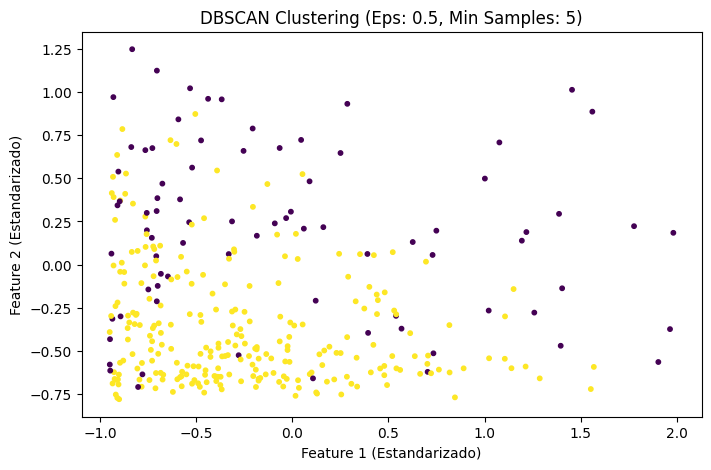

Epsilon: 0.5, Min_samples: 10, Clusters: 2, Noise: 124


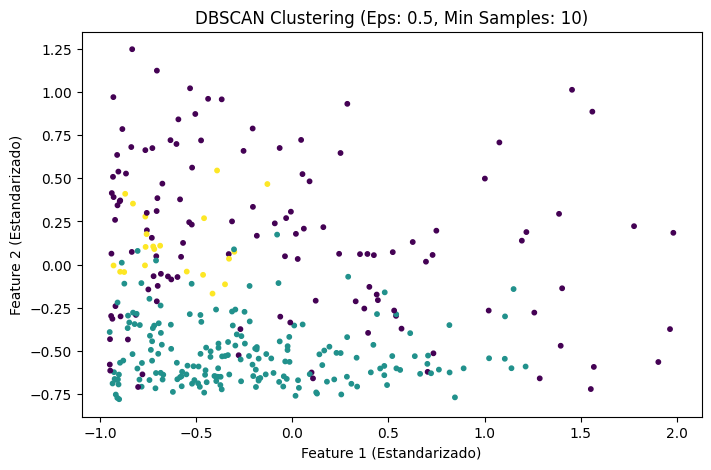

Epsilon: 0.5, Min_samples: 15, Clusters: 1, Noise: 162


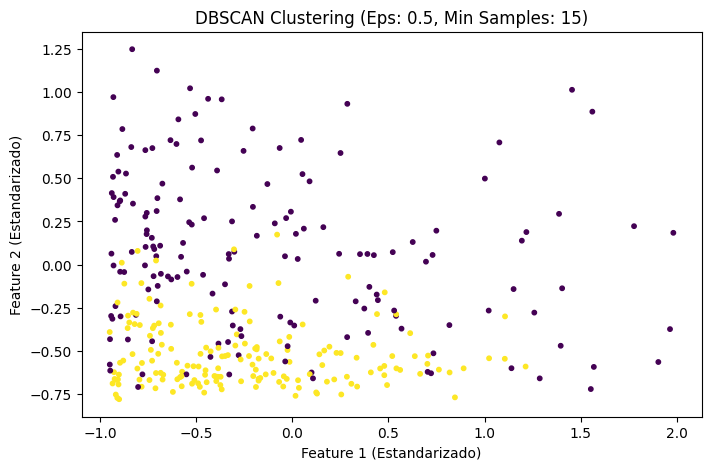

Epsilon: 0.7, Min_samples: 5, Clusters: 1, Noise: 23


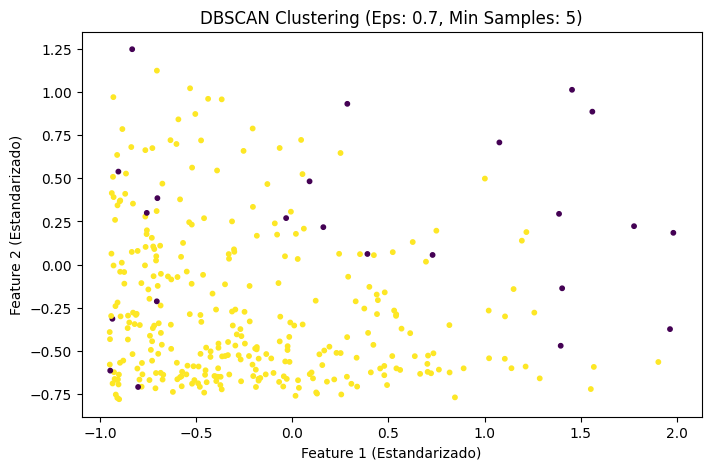

Epsilon: 0.7, Min_samples: 10, Clusters: 1, Noise: 41


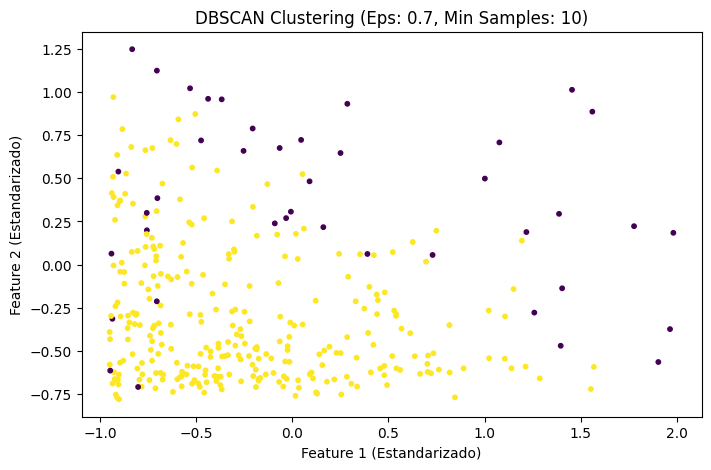

Epsilon: 0.7, Min_samples: 15, Clusters: 1, Noise: 46


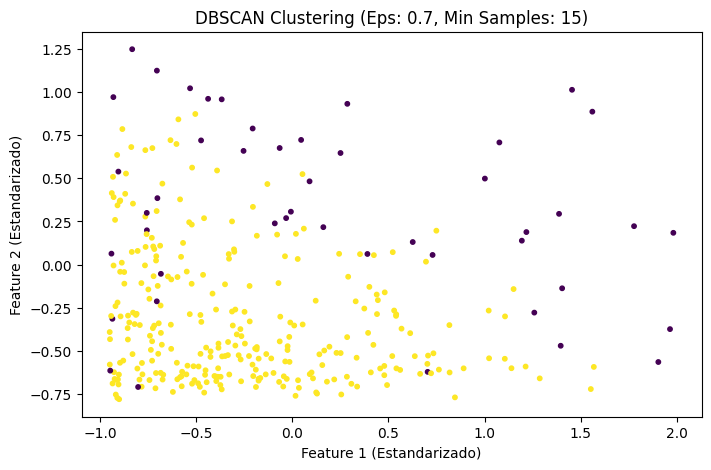

Epsilon: 1.0, Min_samples: 5, Clusters: 1, Noise: 2


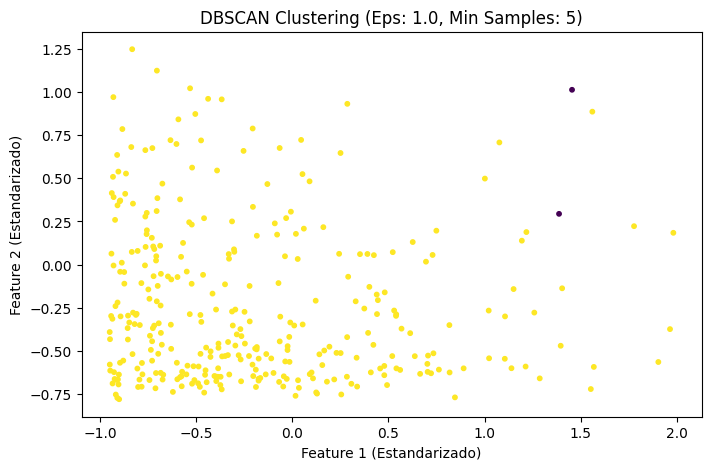

Epsilon: 1.0, Min_samples: 10, Clusters: 1, Noise: 2


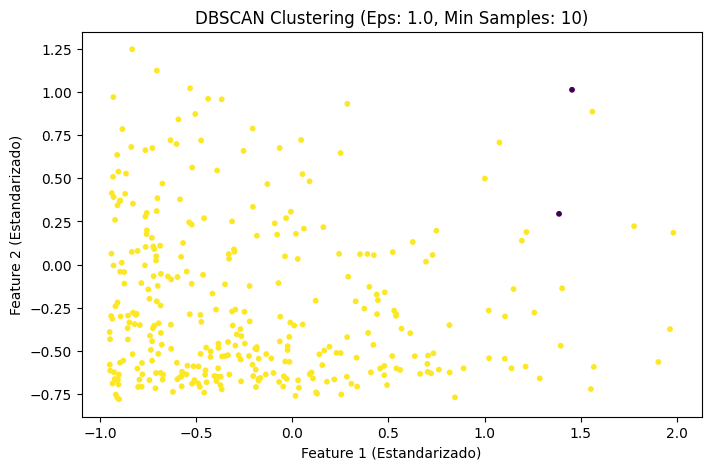

Epsilon: 1.0, Min_samples: 15, Clusters: 1, Noise: 4


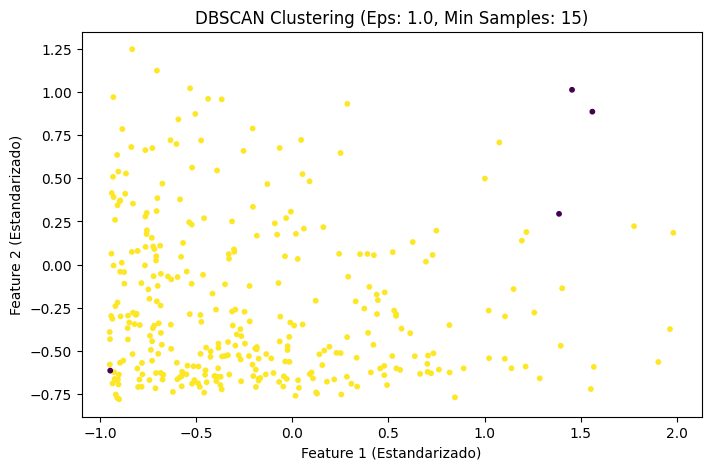

In [14]:
# definimos los parámetros epsilon y min_samples
epsilon_values = [0.5, 0.7, 1.0]  # distancias máximas para considerar dos puntos como vecinos
min_samples_values = [5, 10, 15]   # número mínimo de puntos requeridos para formar un cluster

# aplicamos DBSCAN con diferentes combinaciones de parámetros
for eps in epsilon_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_filtered)

        # contamos cuántos clusters se formaron (incluyendo ruido)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # restamos uno si hay ruido (-1)
        n_noise = list(labels).count(-1)  # contamos los puntos considerados ruido
        
        print(f'Epsilon: {eps}, Min_samples: {min_samples}, Clusters: {n_clusters}, Noise: {n_noise}')

        # visualizamos los resultados del clustering
        plt.figure(figsize=(8, 5))
        plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=labels, cmap='viridis', s=10)
        plt.title(f'DBSCAN Clustering (Eps: {eps}, Min Samples: {min_samples})')
        plt.xlabel('Feature 1 (Estandarizado)')
        plt.ylabel('Feature 2 (Estandarizado)')
        plt.show()

### 4. Visualización de clusters y outliers:
  * Visualiza los clusters formados por DBSCAN en gráficos de dispersión. Utiliza diferentes colores para representar los clusters y marca los outliers con un color distintivo para hacer visible su presencia.
  * Discute la estructura de los clusters encontrados. ¿Hay alguna correlación entre las variables y los clusters? ¿Cómo se distribuyen los outliers en comparación con los datos agrupados?

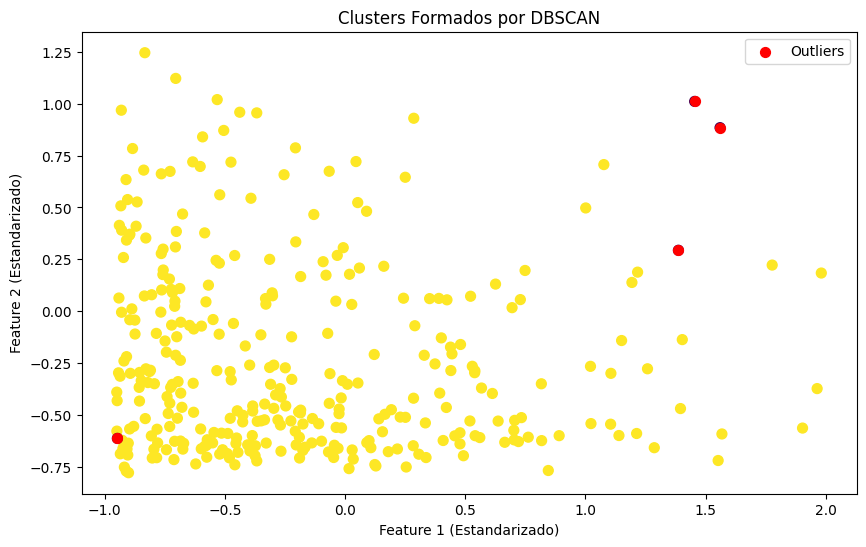

In [15]:
# creamos una figura de tamaño 10x6 para el gráfico
plt.figure(figsize=(10, 6))
# dibujamos un gráfico de dispersión usando las primeras dos características filtradas, 
# coloreadas según las etiquetas de los clusters
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=labels, cmap='viridis', s=50)
# identificamos los outliers, que están etiquetados como -1 en las etiquetas
outliers = labels == -1
# dibujamos los outliers en rojo en el gráfico de dispersión
plt.scatter(X_filtered[outliers][:, 0], X_filtered[outliers][:, 1], color='red', label='Outliers', s=50)
plt.title('Clusters Formados por DBSCAN') # añadimos un título al gráfico
plt.xlabel('Feature 1 (Estandarizado)') # etiquetamos el eje X
plt.ylabel('Feature 2 (Estandarizado)') # etiquetamos el eje Y
plt.legend() # mostramos la leyenda en el gráfico
plt.show() # mostramos el gráfico


### 5. Interpretación de resultados:
  * Evalúa la calidad del agrupamiento. DBSCAN no requiere que se especifique el número de clusters, lo que es una ventaja cuando no se conoce esta información de antemano.
  * Discute la naturaleza de los outliers detectados. ¿Son clientes únicos con comportamientos inusuales? ¿Podrían estos clientes representar oportunidades comerciales o riesgos?

* DBSCAN no requiere que se especifique el número de clusters, lo que es una ventaja cuando no se conoce esta información de antemano. Evaluaremos la calidad del agrupamiento observando la cantidad de clusters formados y la cantidad de outliers detectados.